# Question 1 Part 1

## Description

Read mandril image, Divide the image into blocks with 8x8, 16x16, and 64x64 sizes then apply dct transform then apply the custom mask , finally  apply reverse dct transform and compare the results using mse and psnr method.

## Import required dependencies

- Import cv2 for read and map the color channels
- Import time to timing code speed
- Import numpy to work with arrays
- Import matplotlib to show image for each step

In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

## Read Image

In [2]:
image = cv2.imread("../images/mandril.tiff")

# Convert BGR order to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## Define block sizes and get image size

In [3]:
block_sizes = [64, 16, 8]

image_height, image_width, channels = image.shape

## Define function to divide image into blocks

In [4]:
def devidImage(image, blockSize):
    image_blocks = np.empty(
        (int(image_height / blockSize), int(image_width / blockSize)),
        dtype=object,
    )

    block_height, block_width = image_blocks.shape

    for i in range(block_width):
        for j in range(block_height):
            image_blocks[j, i] = image[
                j * blockSize : (j + 1) * blockSize,
                i * blockSize : (i + 1) * blockSize,
                :,
            ]

    return image_blocks


## Define function to merge image blocks

In [5]:
def mergeBlocks(imageBlocks, image, blockSize):
    result = np.copy(image)

    block_height, block_width = imageBlocks.shape

    for i in range(block_width):
        for j in range(block_height):
            result[j * blockSize:(j + 1) * blockSize,
                   i * blockSize:(i + 1) * blockSize, :, ] = imageBlocks[j, i]

    return result

## Defind function to apply mask

In [6]:
def applyMask(imageBlocks, blockSize):
    mask = np.zeros((blockSize, blockSize))
    mask[0:int(blockSize/2), 0:int(blockSize/2)] = 1
    
    block_height, block_width = imageBlocks.shape

    for i in range(block_width):
        for j in range(block_height):
            for c in range(channels):
                imageBlocks[j, i][c] = mask * imageBlocks[j, i][c]

    return imageBlocks

## Defind function to process image

In [7]:
def process(image, blockSize):
    image_blocks = devidImage(image, blockSize)

    block_height, block_width = image_blocks.shape

    ## apply dtc transform
    for i in range(block_width):
        for j in range(block_height):
            block = image_blocks[j, i]
            block = np.float32(block)/255.0
            image_blocks[j, i] = [
                cv2.dct(block[:, :, x]) for x in range(channels)
            ]

    applyMask(image_blocks, blockSize)

    ## apply reverse dtc transform
    for i in range(block_width):
        for j in range(block_height):
            image_blocks[j, i] = cv2.merge(
                tuple([cv2.idct(image_blocks[j, i][x]) for x in range(channels)])
            )
            image_blocks[j, i] = np.uint8(image_blocks[j, i] * 255.0)

    return mergeBlocks(image_blocks, image, block_size)

## Define function to compare images with mse and psnr

In [8]:
def mse(image_1, image_2):
    return ((image_1 - image_2) ** 2).sum() / \
        (image_1.shape[0] * image_1.shape[1])

def psnr(image_1, image_2):
    mse_value = mse(image_1, image_2)
    return 10 * np.log((255 ** 2) / mse_value)

def compare(image_1, image_2):
    mse_value = mse(image_1, image_2)
    psnr_value = psnr(image_1, image_2)
    print("MSE: {:.2f} PSNR: {:.2f}".format(mse_value, psnr_value))

## Getting Start

Block Size: 64
Time: 0.020910024642944336
MSE: 197.13 PSNR: 57.99

Block Size: 16
Time: 0.05388188362121582
MSE: 197.93 PSNR: 57.95

Block Size: 8
Time: 0.12164187431335449
MSE: 198.71 PSNR: 57.91



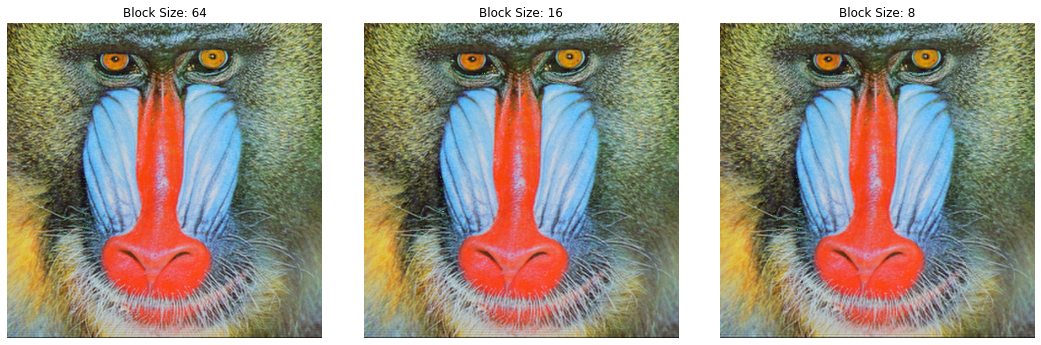

In [9]:
f, subplt = plt.subplots(1,3,figsize=(15,5))
plt.tight_layout()

for i in range(len(block_sizes)):
    block_size = block_sizes[i]

    t0 = time.time()
    result = process(image, block_size)
    t1 = time.time()

    print("Block Size: {}".format(block_size))
    print("Time: {}".format(t1 - t0))
    compare(image, result)

    print()

    subplt[i].axis('off')
    subplt[i].imshow(result)
    subplt[i].set_title('Block Size: {}'.format(block_size))


As result, according to the mse and psnr value we realize when the block size increased the mask effect decreased so we have less compression and by increasing the block size the code speed increased